# Projeto *Molecular Dynamics*

* Aluno : Gabriel Wendell Celestino Rocha
* Matrícula :  20190112149 

* Disciplina : Física Computacional II
* Professor : Leonardo Machado
* Data de Entrega : 26/04/2021

In [1]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import sys

%matplotlib notebook

## Parte 1

Vamos modificar o programa contido no arquivo `MD.py` de forma que possamos calcular a energia cinética, potencial e total do nosso sistema físico. Vamos começar implementando novamente o código contido no arquivo em questão.

Começamos definindo um arquivo de saída:

In [2]:
output = open('MD_Arg1.xyz','w')

Definimos uma função que irá descrever a trajetória das partículas:

In [3]:
def dump():
    output.write('{0:d} \n'.format(N))
    output.write('\n')
    for i in range(N):
        output.write('1 {0:.3f} {1:.3f} 0.000 \n'.format(x[i],y[i])) 

Agora definimos outra função para calcular a força de interação entre as partículas. Primeiramente implementamos o raio de *cut-off*. Em seguida, aplicamos uma análise para configurações iniciais onde os átomos estão muito próximos uns dos outros (assim podemos evitar que os átomos saiam da caixa):

In [4]:
def f(r):
    if r > rcut:
        return 0.0
    else:
        f = 24.0 * eps * (2.0*(1/r)**(13) - (1.0/r)**(7))
        
        if (f < 100000):
            return f
        else:
            return 100000.0

Definimos mais uma função, dessa vez para determinar as posições iniciais dos átomos:

In [5]:
def init_pos():
    for i in range(N):
        x[i] = L/(Nx) * (i%(Nx)) + rd.random()*rfac*(L/Nx) 
        divy = N/Ny
        y[i] = L/Ny * int((i/divy)) + rd.random()*rfac*(L/Ny) 

Definimos mais uma função, mas dessa vez para calcular as velocidades iniciais dos átomos:

In [6]:
def init_vel():
    for i in range(N):
        vx[i] = 2.0*v0*(rd.random()-0.5)
        vy[i] = 2.0*v0*(rd.random()-0.5)

Definimos uma função para inicializar as posições e velocidades anteriores:

In [7]:
def init_prev():
    for i in range(N):
        xprev[i] = x[i] - vx[i]*dt
        yprev[i] = y[i] - vy[i]*dt

Agora vamos definir os parâmetros que serão utilizados ao longo da simulação:

In [8]:
eps = 1.0
N = 4
Nx = 2
Ny = 2
v0 = 1.0
rfac = 0.4
L = 10
dt = 0.005
Nstep = 20000
rcut = 3.0
tsave = 0.1

Fazemos uma análise para avaliar se o arranjo escolhido dos átomos é consistente ou não:

In [9]:
if (Nx*Ny != N):
    print("O arranjo escolhido de átomos não é consistente com o número total de átomos.")
    sys.exit()

Definimos mais uma função, dessa vez para determinar a energia cinética através do teorema trabalho-energia:

In [10]:
def Ek(v):
    return 0.5*eps*np.dot(v,v) 

Definimos uma função para o cálculo das forças:

In [11]:
def calcforces():
    for j in range(N):
        if (j != i):
            xji = x[j] - x[i]
            if (xji > 0.5*L):
                xji = xji - L
            elif (xji < -0.5*L):
                xji = xji + L
                
            yji = y[j] - y[i]
            if (yji > 0.5*L):
                yji = yji - L
            elif (yji < -0.5*L):
                yji = yji + L
                
            rji = np.sqrt(xji**2 + yji**2)
            fji = f(rji)
            cos = -xji/rji
            sin = -yji/rji
            fx[i]+= fji*cos
            fy[i]+= fji*sin

Definimos mais uma função, dessa vez para calcular a energia potencial do sistema:

In [12]:
def cW(F,v):
    return np.dot(F,v)

Inicializamos algumas variáveis:

In [13]:
x = np.zeros(N,float)
y = np.zeros(N,float)
vx = np.zeros(N,float)
vy = np.zeros(N,float)
xprev = np.zeros(N,float)
yprev = np.zeros(N,float)
xnew = np.zeros(N,float)
ynew = np.zeros(N, float)
fx = np.zeros(N,float)
fy = np.zeros(N,float)

Agora calculamos as posições e velocidade iniciais e as anteriores e a trajetórias das partículas:

In [14]:
init_pos()
init_vel()
init_prev()
dump()

Agora realizamos a simulação propriamente dita:

In [15]:
t = 0
tol1 = 1.0e-6
tol2 = 1.0e-4
Ek_points = [] 
W_points = []
Work = 0.0

while (t < (Nstep*dt)):
    t += dt
    for i in range(N):
        fx[i] = 0.0
        fy[i] = 0.0
        calcforces()

        xnew[i] = 2.0*x[i] - xprev[i] + fx[i]*dt**2
        if xnew[i] < 0.0:
            xnew[i] += L
            x[i] += L 
            xprev[i] += L
        elif xnew[i] > L:
            xnew[i] -= L
            x[i] -= L
            xprev[i] -= L

        ynew[i] = 2.0*y[i] - yprev[i] + fy[i]*dt**2
        if ynew[i] < 0.0:
            ynew[i] += +L
            y[i] += L
            yprev[i] += L
        elif ynew[i] > L:
            ynew[i] -= L
            y[i] -= L
            yprev[i] -= L

        vx[i] = (xnew[i] - xprev[i])/(2*dt)
        vy[i] = (ynew[i] - yprev[i])/(2*dt)
        
    for part in range(N):
        Work -= cW(np.array([fx[part],fy[part]],float),np.array([vx[part],vy[part]],float))*dt
        
    xprev = np.copy(x)
    yprev = np.copy(y)
    x = np.copy(xnew)
    y = np.copy(ynew)
    # dump()
    
    if ((t+tol1)%tsave < tol2):
        # print(t)
        dump()

    E = 0
    for vel_part in range(N):
        E += Ek(np.array([vx[vel_part],vy[vel_part]],float))
    Ek_points.append(E)
    W_points.append(Work)

output.close()

Tendo então implementado novamente o código contido no arquivo `MD.py`, podemos avançar para a parte gráfica do problema. Como de costume, vamos definir uma função para melhorar a estética dos nossos plots:

In [16]:
def opt_plot():
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",
                    top = True,right = True, length=5,width=1,labelsize=15)
    plt.tick_params(axis='both',which='major', direction = "in",
                    top = True,right = True, length=8,width=1,labelsize=15)

Calculamos a energia total do sistema:

In [17]:
Et = np.array(Ek_points,float) + np.array(W_points,float)

Finalmente, vamos ao plot:

<IPython.core.display.Javascript object>


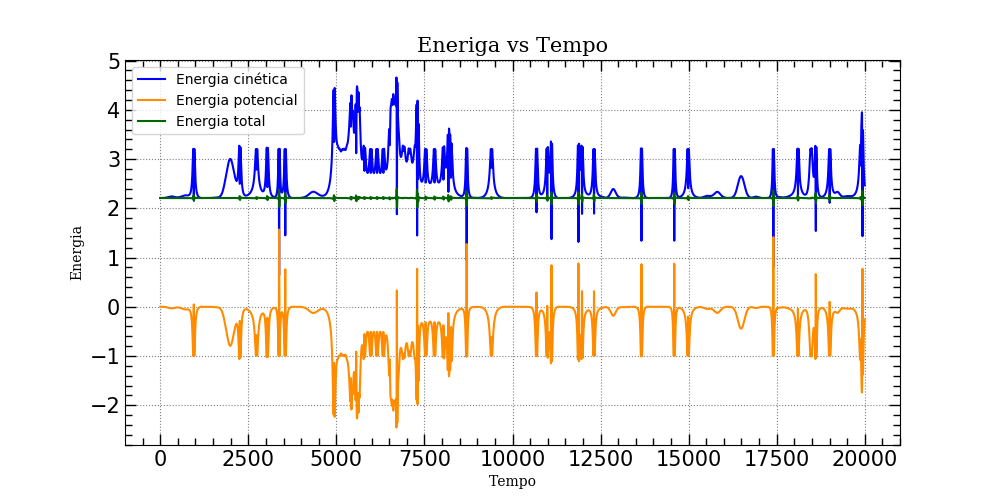

In [18]:
plt.figure(figsize=(10,5))

plt.plot(Ek_points, color='blue', label=r'Energia cinética')
plt.plot(W_points, color='darkorange', label=r'Energia potencial')
plt.plot(Et, 'darkgreen', label=r'Energia total')
plt.title('Eneriga vs Tempo', fontsize=15, family='serif')
plt.xlabel('Tempo', fontsize=10, family='serif')
plt.ylabel('Energia', fontsize=10, family='serif')
plt.legend(loc='best')
opt_plot()

$\blacksquare$

## Parte 2

Vamos agora tentar simular o processo de derretimento de um sólido. Primeiramente, vamos determinar um regime no qual os átomos de argônio (usaremos os átomos de argônio como referência) formam um sólido. Para isto, vamos aumentar a densidade dos átomos e reduzir suas velocidades.

Para isso, vamos realizar algumas alterações no código presente no arquivo `MD.py`:

In [19]:
output = open('MD_Arg2.xyz','w')

def dump():
    output.write('{0:d} \n'.format(N))
    output.write('\n')
    for i in range(N):
        output.write('1 {0:.3f} {1:.3f} 0.000 \n'.format(x[i], y[i]))

def init_vel():
    for i in range(N):
        vx[i] = 2.0*v0*(rd.random()-0.5)
        vy[i] = 2.0*v0*(rd.random()-0.5)

def init_prev():
    for i in range(N):
        xprev[i] = x[i]-vx[i]*dt
        yprev[i] = y[i]-vy[i]*dt

def f(r):
    if r > rcut:
        return 0.0
    else:
        f = 24.0*eps*( 2.0*(1/r)**(13) -  (1.0/r)**(7))
        
        if (f < 100000):
            return f
        else:
            return 100000.0

        
eps = 1.0
N = 25
Nx = 5
Ny = 5
v0 = 0.0000000000001
rfac = 0.4
L = 10
dt = 0.005
Nstep = 20000
rcut = 3.0
tsave = 0.1


def calcforces():
    for j in range(N):
        if (j != i):
            xji = x[j] - x[i]
            if (xji > 0.5*L):
                xji = xji - L
            elif (xji < -0.5*L):
                xji = xji + L
                
            yji = y[j] - y[i]
            if (yji > 0.5*L):
                yji = yji - L
            elif (yji < -0.5*L):
                yji = yji + L
                
            rji = np.sqrt(xji**2 + yji**2)
            fji = f(rji)
            cos = -xji/rji
            sin = -yji/rji
            fx[i]+= fji*cos
            fy[i]+= fji*sin
            

x = np.zeros(N,float)
y = np.zeros(N,float)
vx = np.zeros(N,float)
vy = np.zeros(N,float)
xprev = np.zeros(N,float)
yprev = np.zeros(N,float)
xnew = np.zeros(N,float)
ynew = np.zeros(N, float)
fx = np.zeros(N,float)
fy = np.zeros(N,float)



x[0:5] = L/2-2
for i in range(Ny):
    y[i] = i*2

x[5:10] = L/2
for i in range(Ny):
    y[i+5] = i*2
x[10:15] = L/2+2
for i in range(Ny):
    y[i+10] = i*2
x[15:20] = L/2+4
for i in range(Ny):
    y[i+15] = i*2
x[20:25] = L/2+6
for i in range(Ny):
    y[i+20] = i*2


init_vel()
init_prev()
dump()


t = 0
tol1 = 1.0e-6
tol2 = 1.0e-4

while (t < (Nstep*dt)):
    t += dt
    for i in range(N):
        fx[i] = 0.0
        fy[i] = 0.0
        calcforces()

        xnew[i] = 2.0*x[i] - xprev[i] + fx[i]*dt**2
        if xnew[i] < 0.0:
            xnew[i] += L
            x[i] += L 
            xprev[i] += L
        elif xnew[i] > L:
            xnew[i] -= L
            x[i] -= L
            xprev[i] -= L

        ynew[i] = 2.0*y[i] - yprev[i] + fy[i]*dt**2
        if ynew[i] < 0.0:
            ynew[i] += +L
            y[i] += L
            yprev[i] += L
        elif ynew[i] > L:
            ynew[i] -= L
            y[i] -= L
            yprev[i] -= L

        vx[i] = (xnew[i]-xprev[i])/(2*dt)
        vy[i] = (ynew[i]-yprev[i])/(2*dt)
        
    xprev = np.copy(x)
    yprev = np.copy(y)
    
    x = np.copy(xnew)
    y = np.copy(ynew)
    # dump() 
    
    if ((t + tol1)%tsave < tol2):
        print(t)
        dump()

output.close()

0.10000000000000002
0.2000000000000001
0.30000000000000016
0.40000000000000024
0.5000000000000003
0.6000000000000004
0.7000000000000005
0.8000000000000006
0.9000000000000007
1.0000000000000007
1.0999999999999985
1.1999999999999964
1.2999999999999943
1.3999999999999921
1.49999999999999
1.5999999999999879
1.6999999999999857
1.7999999999999836
1.8999999999999815
1.9999999999999793
2.0999999999999774
2.1999999999999753
2.299999999999973
2.399999999999971
2.499999999999969
2.599999999999967
2.6999999999999647
2.7999999999999625
2.8999999999999604
2.9999999999999583
3.099999999999956
3.199999999999954
3.299999999999952
3.3999999999999497
3.4999999999999476
3.5999999999999455
3.6999999999999433
3.799999999999941
3.899999999999939
3.999999999999937
4.099999999999935
4.199999999999933
4.2999999999999305
4.399999999999928
4.499999999999926
4.599999999999924
4.699999999999922
4.79999999999992
4.899999999999918
4.999999999999916
5.0999999999999135
5.199999999999911
5.299999999999909
5.399999999999

44.50000000000431
44.600000000004364
44.700000000004415
44.80000000000447
44.90000000000452
45.00000000000457
45.10000000000462
45.20000000000467
45.30000000000472
45.40000000000477
45.500000000004825
45.600000000004876
45.70000000000493
45.80000000000498
45.90000000000503
46.00000000000508
46.10000000000513
46.20000000000518
46.300000000005234
46.400000000005285
46.500000000005336
46.60000000000539
46.70000000000544
46.80000000000549
46.90000000000554
47.00000000000559
47.10000000000564
47.200000000005694
47.300000000005745
47.4000000000058
47.50000000000585
47.6000000000059
47.70000000000595
47.800000000006
47.90000000000605
48.000000000006104
48.100000000006155
48.200000000006206
48.30000000000626
48.40000000000631
48.50000000000636
48.60000000000641
48.70000000000646
48.80000000000651
48.900000000006564
49.000000000006615
49.100000000006666
49.20000000000672
49.30000000000677
49.40000000000682
49.50000000000687
49.60000000000692
49.70000000000697
49.800000000007024
49.9000000000070

90.59999999999009
90.69999999999
90.79999999998991
90.89999999998982
90.99999999998973
91.09999999998963
91.19999999998954
91.29999999998945
91.39999999998936
91.49999999998927
91.59999999998918
91.69999999998909
91.799999999989
91.8999999999889
91.99999999998882
92.09999999998873
92.19999999998863
92.29999999998854
92.39999999998845
92.49999999998836
92.59999999998827
92.69999999998818
92.79999999998809
92.899999999988
92.9999999999879
93.09999999998782
93.19999999998772
93.29999999998763
93.39999999998754
93.49999999998745
93.59999999998736
93.69999999998727
93.79999999998718
93.89999999998709
93.999999999987
94.0999999999869
94.19999999998682
94.29999999998672
94.39999999998663
94.49999999998654
94.59999999998645
94.69999999998636
94.79999999998627
94.89999999998618
94.99999999998609
95.099999999986
95.1999999999859
95.29999999998581
95.39999999998572
95.49999999998563
95.59999999998554
95.69999999998545
95.79999999998536
95.89999999998527
95.99999999998518
96.09999999998509
96.1999

Note que ao rodar o programa acima, temos uma certa instabilidade em tempos prolongados. Essa instabilidade eventualmente fazem com que o nosso sistema acabe colapsando de forma expontânea. Esse colapso gera um objeto de energia muito elevada, que por sua vez constitui um efeito não-físico. Entretanto, para intervalos de tempo cada vez mais próximos do tempo inicial, o sistema tende a se aproximar cada vez mais de um sistema estável.

$\blacksquare$

## Parte 3

Vamos agora simular a colisão de um átomo de argônio com um sólido. Para isso, vamos gerar uma estrutura inicial e testar várias velocidades iniciais para um átomo isolado.

Para isso, vamos realizar algumas alterações no código presente no arquivo `MD.py`:

In [20]:
output = open('MD_Arg3.xyz','w')

def dump():
    output.write('{0:d} \n'.format(N))
    output.write('\n')
    for i in range(N):
        output.write( '1 {0:.3f} {1:.3f} 0.000 \n'.format(x[i], y[i]))
        
def f(r):
    if r > rcut:
        return 0.0
    else:
        f = 24.0*eps*( 2.0*(1/r)**(13) -  (1.0/r)**(7))
        
        if (f < 100000):
            return f
        else:
            return 100000.0
        
        
eps = 1.0        
N = 26
Nx = 5
Ny = 5
v0 = 0.0
rfac = 0.0
L = 10
dt = 0.005
Nstep = 20000
rcut = 3.0
tsave = 0.1


def calcforces():
    for j in range(N):
        if (j != i):
            xji = x[j] - x[i]
            if (xji > 0.5*L):
                xji = xji - L
            elif (xji < -0.5*L):
                xji = xji + L
                
            yji = y[j] - y[i]
            if (yji>0.5*L):
                yji = yji - L
            elif (yji < -0.5*L):
                yji = yji + L
                
            rji = np.sqrt(xji**2 + yji**2)
            fji = f(rji)
            cos = -xji/rji
            sin = -yji/rji
            fx[i]+= fji*cos
            fy[i]+= fji*sin
            

x = np.zeros(N,float)
y = np.zeros(N,float)
vx = np.zeros(N,float)
vy = np.zeros(N,float)
xprev = np.zeros(N,float)
yprev = np.zeros(N,float)
xnew = np.zeros(N,float)
ynew = np.zeros(N, float)
fx = np.zeros(N,float)
fy = np.zeros(N,float)


x[0:5] = L/2-2
for i in range(Ny):
    y[i] = i*2

x[5:10] = L/2
for i in range(Ny):
    y[i+5] = i*2
    
x[10:15] = L/2+2
for i in range(Ny):
    y[i+10] = i*2
    
x[15:20] = L/2+4
for i in range(Ny):
    y[i+15] = i*2
    
x[20:25] = L/2+6
for i in range(Ny):
    y[i+20] = i*2
    
    
x[25] = -L/2 - 10 
y[25] = 1.5
vx[25] = 0.001 


init_prev()
dump()


t = 0
tol1 = 1.0e-6
tol2 = 1.0e-4

while (t < (Nstep*dt)):
    t += dt
    for i in range(N):
        fx[i] = 0.0
        fy[i] = 0.0
        calcforces()

        xnew[i] = 2.0*x[i] - xprev[i] + fx[i]*dt**2
        if xnew[i] < 0.0:
            xnew[i] += L
            x[i] += L 
            xprev[i] += L
        elif xnew[i] > L:
            xnew[i] -= L
            x[i] -= L
            xprev[i] -= L

        ynew[i] = 2.0*y[i] - yprev[i] + fy[i]*dt**2
        if ynew[i] < 0.0:
            ynew[i] += +L
            y[i] += L
            yprev[i] += L
        elif ynew[i] > L:
            ynew[i] -= L
            y[i] -= L
            yprev[i] -= L

        vx[i] = (xnew[i]-xprev[i])/(2*dt)
        vy[i] = (ynew[i]-yprev[i])/(2*dt)
        
    xprev = np.copy(x)
    yprev = np.copy(y)
    x = np.copy(xnew)
    y = np.copy(ynew)
    # dump()
    
    if ((t + tol1)%tsave < tol2):
        print(t)
        dump()

output.close()

0.10000000000000002
0.2000000000000001
0.30000000000000016
0.40000000000000024
0.5000000000000003
0.6000000000000004
0.7000000000000005
0.8000000000000006
0.9000000000000007
1.0000000000000007
1.0999999999999985
1.1999999999999964
1.2999999999999943
1.3999999999999921
1.49999999999999
1.5999999999999879
1.6999999999999857
1.7999999999999836
1.8999999999999815
1.9999999999999793
2.0999999999999774
2.1999999999999753
2.299999999999973
2.399999999999971
2.499999999999969
2.599999999999967
2.6999999999999647
2.7999999999999625
2.8999999999999604
2.9999999999999583
3.099999999999956
3.199999999999954
3.299999999999952
3.3999999999999497
3.4999999999999476
3.5999999999999455
3.6999999999999433
3.799999999999941
3.899999999999939
3.999999999999937
4.099999999999935
4.199999999999933
4.2999999999999305
4.399999999999928
4.499999999999926
4.599999999999924
4.699999999999922
4.79999999999992
4.899999999999918
4.999999999999916
5.0999999999999135
5.199999999999911
5.299999999999909
5.399999999999

44.50000000000431
44.600000000004364
44.700000000004415
44.80000000000447
44.90000000000452
45.00000000000457
45.10000000000462
45.20000000000467
45.30000000000472
45.40000000000477
45.500000000004825
45.600000000004876
45.70000000000493
45.80000000000498
45.90000000000503
46.00000000000508
46.10000000000513
46.20000000000518
46.300000000005234
46.400000000005285
46.500000000005336
46.60000000000539
46.70000000000544
46.80000000000549
46.90000000000554
47.00000000000559
47.10000000000564
47.200000000005694
47.300000000005745
47.4000000000058
47.50000000000585
47.6000000000059
47.70000000000595
47.800000000006
47.90000000000605
48.000000000006104
48.100000000006155
48.200000000006206
48.30000000000626
48.40000000000631
48.50000000000636
48.60000000000641
48.70000000000646
48.80000000000651
48.900000000006564
49.000000000006615
49.100000000006666
49.20000000000672
49.30000000000677
49.40000000000682
49.50000000000687
49.60000000000692
49.70000000000697
49.800000000007024
49.9000000000070

90.39999999999027
90.49999999999018
90.59999999999009
90.69999999999
90.79999999998991
90.89999999998982
90.99999999998973
91.09999999998963
91.19999999998954
91.29999999998945
91.39999999998936
91.49999999998927
91.59999999998918
91.69999999998909
91.799999999989
91.8999999999889
91.99999999998882
92.09999999998873
92.19999999998863
92.29999999998854
92.39999999998845
92.49999999998836
92.59999999998827
92.69999999998818
92.79999999998809
92.899999999988
92.9999999999879
93.09999999998782
93.19999999998772
93.29999999998763
93.39999999998754
93.49999999998745
93.59999999998736
93.69999999998727
93.79999999998718
93.89999999998709
93.999999999987
94.0999999999869
94.19999999998682
94.29999999998672
94.39999999998663
94.49999999998654
94.59999999998645
94.69999999998636
94.79999999998627
94.89999999998618
94.99999999998609
95.099999999986
95.1999999999859
95.29999999998581
95.39999999998572
95.49999999998563
95.59999999998554
95.69999999998545
95.79999999998536
95.89999999998527
95.9999

Note que ao rodar o programa, encontramos alguns problemas, como por exemplo algumas moléculas escapam da caixa. Esse escapamento é um efeito da própria simulação. Por outro lado, mesmo diante desse problema ainda é possível notar diversas características físicas relevantes. Perceba que, em nossa simulação, as moléculas aparentam reagir de acordo com a proporção da velocidade da partícula livre.

Entretanto, um fato não esperado é que o arranjo de átomos de argônio, ao ser atingido pela partícula livre, tem uma reação mais intensa na parte interna do sistema. Se pensarmos nos átomos de argônio como partículas de massa $m$, temos pela conservação do *momentum* da Mecânica Clássica que a última coluna de átomos deveria ser a mais afetada pela transferência de momento linear e não as mais centrais (que no caso são as colunas mais internas).

$\blacksquare$